In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import folium as fl
import geopandas as gpd

plt.style.use('dark_background')

In [31]:
df = pd.read_csv('cleaned.csv', parse_dates=['datetime']).set_index('datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420768 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PM2.5    412029 non-null  float64
 1   PM10     414319 non-null  float64
 2   SO2      411747 non-null  float64
 3   NO2      408652 non-null  float64
 4   CO       400067 non-null  float64
 5   O3       407491 non-null  float64
 6   TEMP     420370 non-null  float64
 7   PRES     420375 non-null  float64
 8   DEWP     420365 non-null  float64
 9   RAIN     420378 non-null  float64
 10  wd       418946 non-null  object 
 11  WSPM     420450 non-null  float64
 12  station  420768 non-null  object 
dtypes: float64(11), object(2)
memory usage: 44.9+ MB


In [32]:
df_interp = pd.read_csv('cleaned_interp.csv', parse_dates=['datetime']).set_index('datetime')
df_interp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420768 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PM2.5    420768 non-null  float64
 1   PM10     420768 non-null  float64
 2   SO2      420768 non-null  float64
 3   NO2      420768 non-null  float64
 4   CO       420768 non-null  float64
 5   O3       420768 non-null  float64
 6   TEMP     420768 non-null  float64
 7   PRES     420768 non-null  float64
 8   DEWP     420768 non-null  float64
 9   RAIN     420768 non-null  float64
 10  WSPM     420768 non-null  float64
 11  station  420768 non-null  object 
 12  wd       418946 non-null  object 
dtypes: float64(11), object(2)
memory usage: 44.9+ MB


In [33]:
df[df.select_dtypes(include='float64').columns].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [34]:
df_interp[df_interp.select_dtypes(include='float64').columns].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,79.839718,104.910268,15.913090,50.600220,1235.682649,57.237872,13.531692,1010.753337,2.482421,0.064428,1.730034
std,80.950217,92.431422,21.896609,35.170876,1161.790893,57.135195,11.437867,10.474302,13.797675,0.820638,1.246674
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,10.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,44.000000,14.500000,1010.400000,3.000000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [35]:
def monthly_mean_pollutant_conc(df):
    stations = df['station'].unique()
    num_stations = len(stations)
    pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

    monthly_avg = df.drop('wd', axis=1).groupby('station').resample('ME').mean().reset_index()

    fig, axes = plt.subplots(nrows = num_stations//2, ncols = 2, sharex = True, figsize = (12, 2 * num_stations))
    axes = axes.ravel()

    for ax, station in zip(axes, stations):
        station_data = monthly_avg[monthly_avg['station'] == station]

        for pollutant in pollutants:
            ax.plot(station_data['datetime'], station_data[pollutant], label = pollutant)
        ax.set_title(f'Monthly Mean Concentrations of Pollutants  - {station}')
        ax.set_ylabel(r'Concentration ($\mu g/m^3$)')
        ax.legend()

    plt.xlabel('Date')
    plt.tight_layout
    plt.show()    

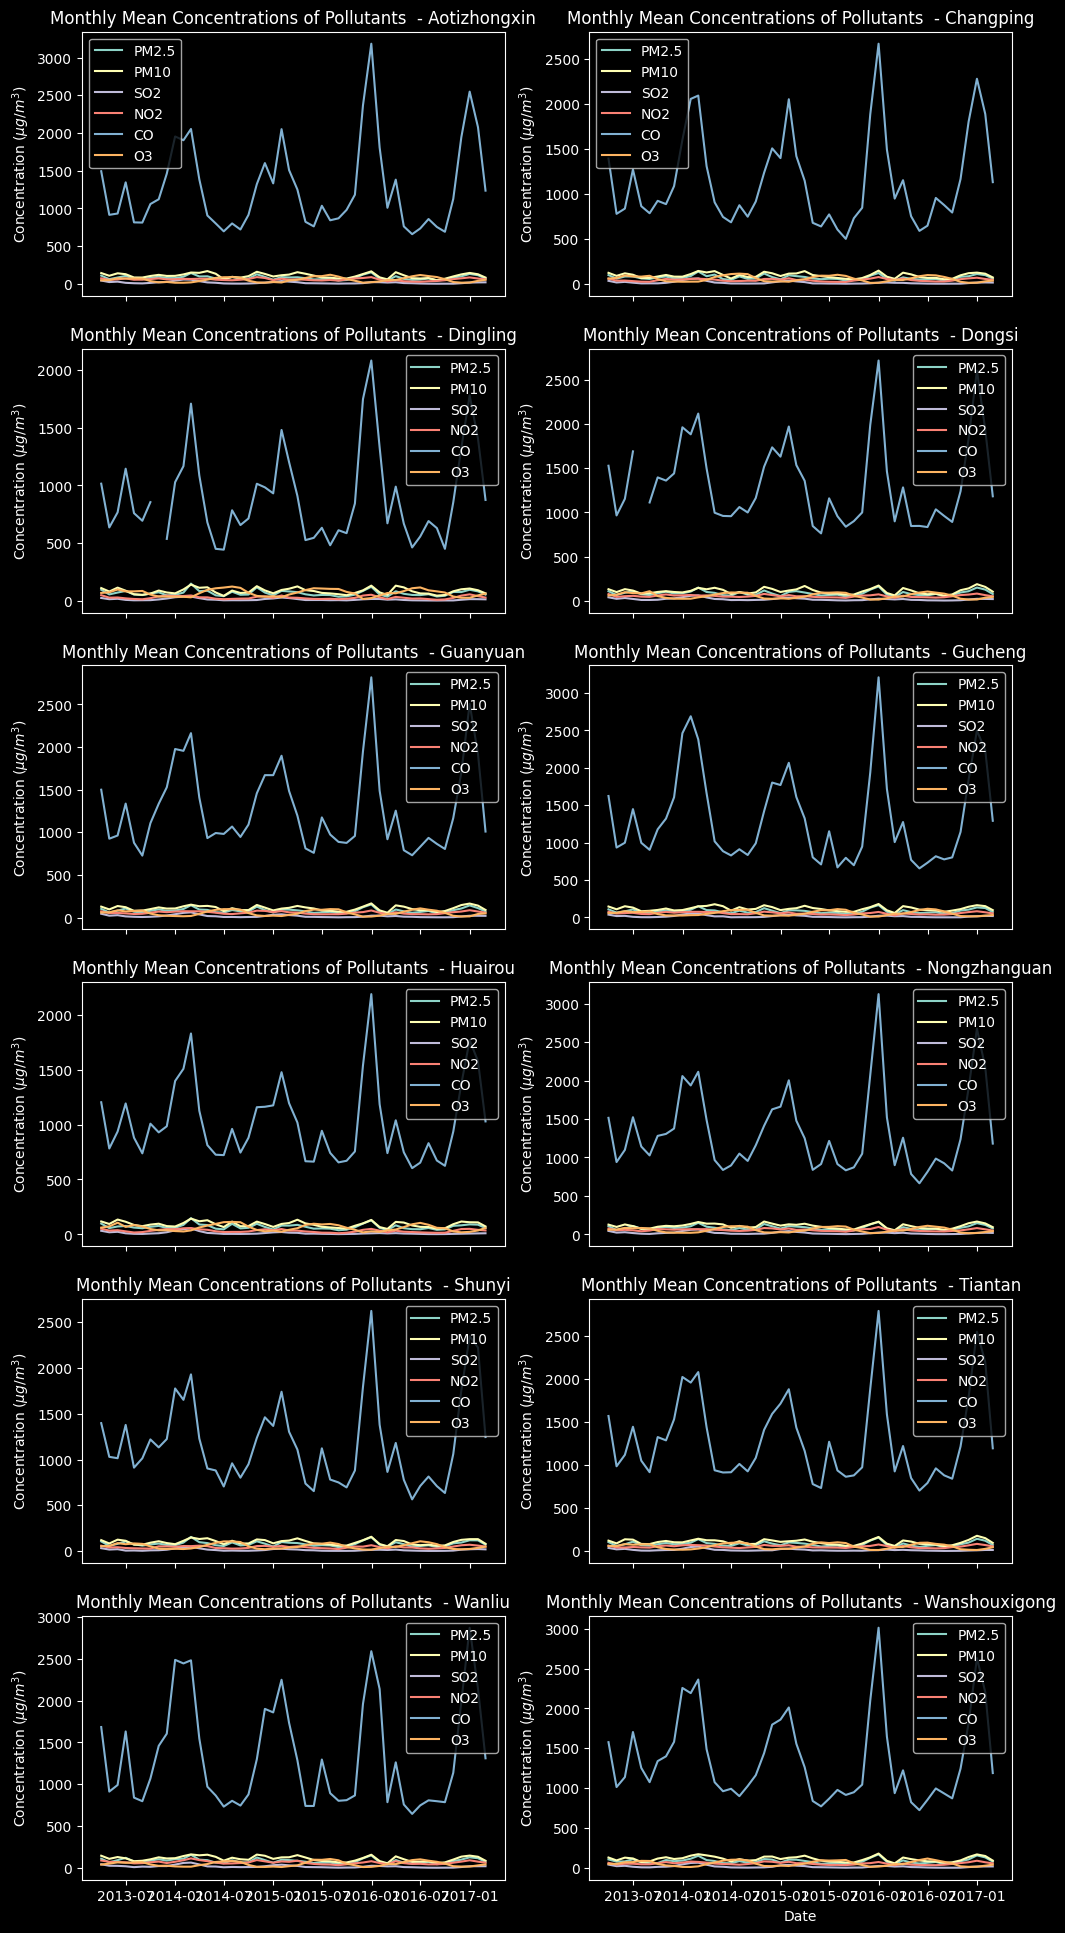

In [36]:
monthly_mean_pollutant_conc(df)

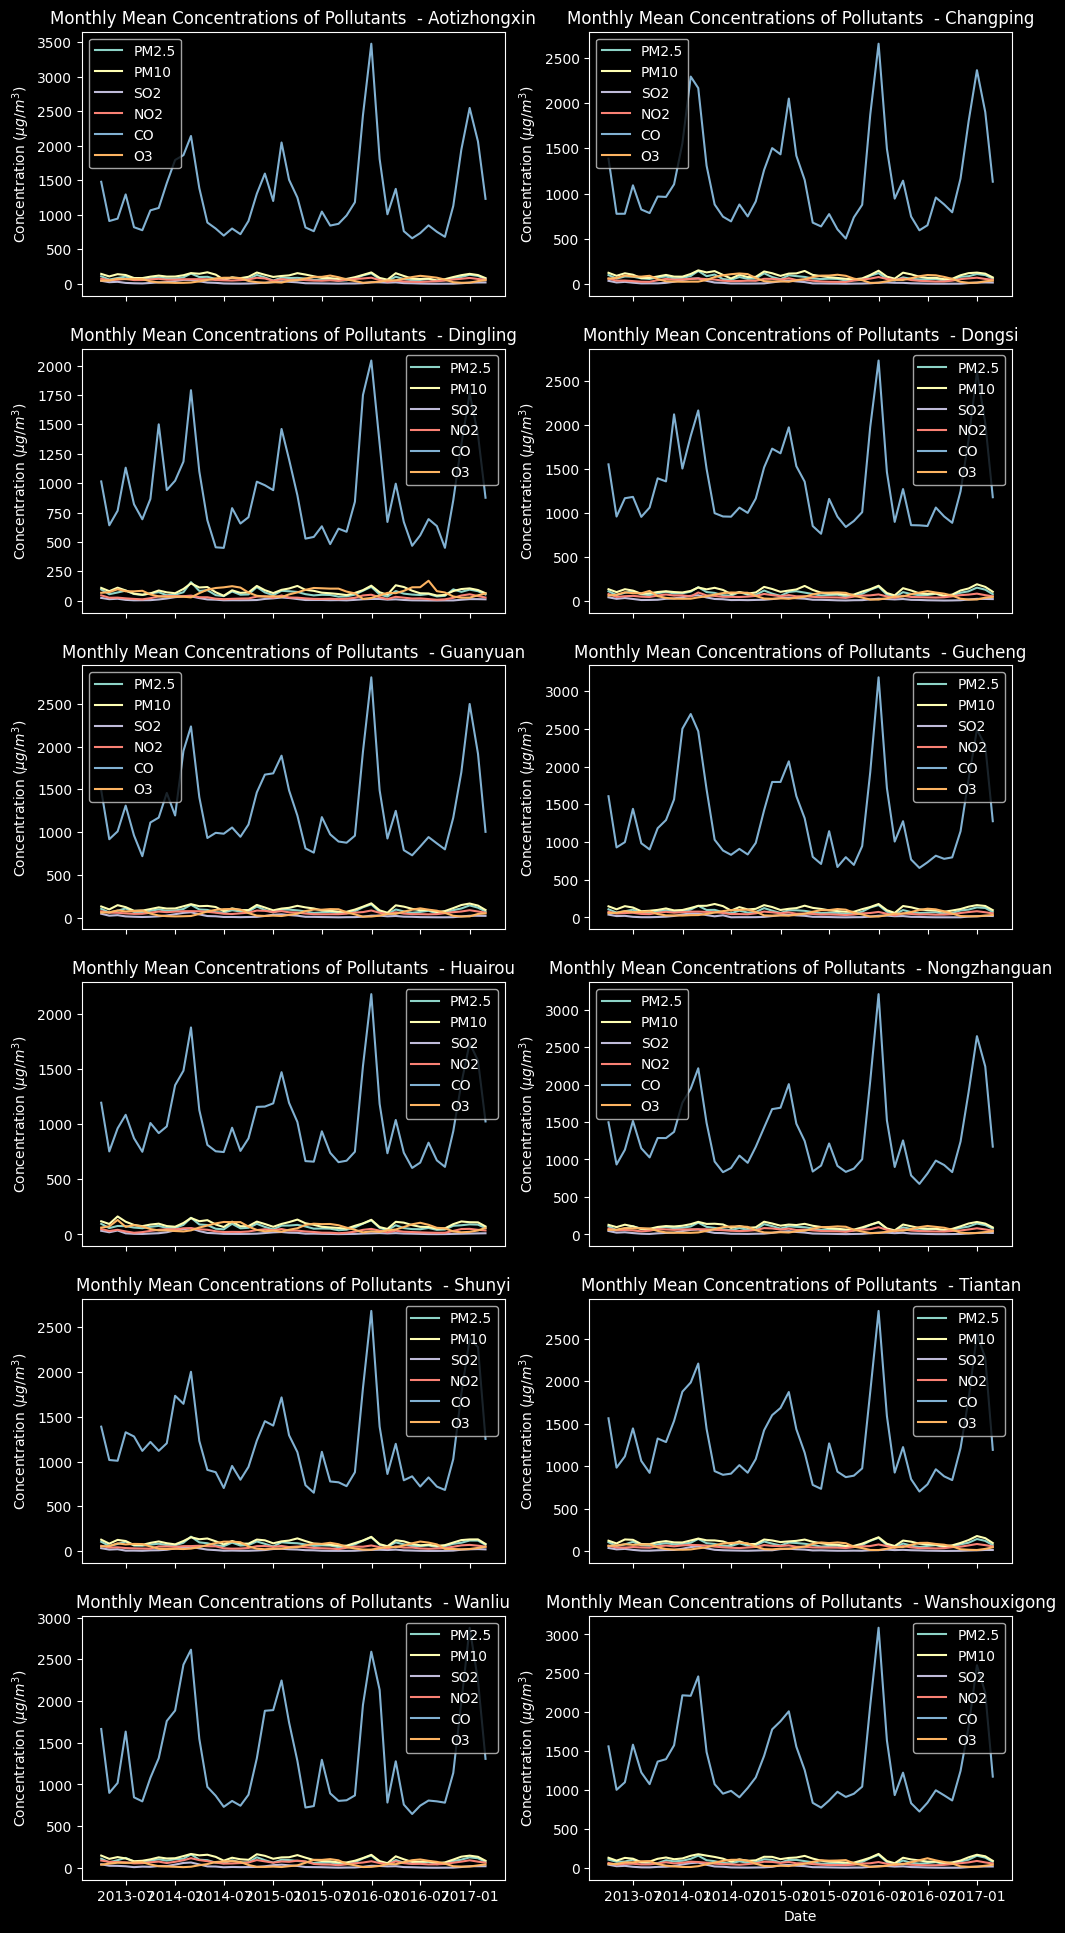

In [37]:
monthly_mean_pollutant_conc(df_interp)

<Axes: >

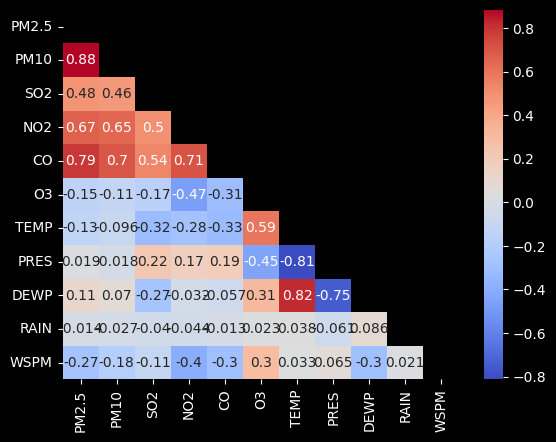

In [38]:
corr_matrix = df[df.select_dtypes(include='float64').columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')

In [39]:
def correlation_scatter(df, var1, var2):   
    stations = df['station'].unique()
    num_stations = len(stations)

    monthly_avg = df.drop('wd', axis=1).groupby('station').resample('ME').mean().reset_index()
    
    fig, axes = plt.subplots(nrows=num_stations//2, ncols=2, sharex=True, figsize=(12, 2 * num_stations))
    axes = axes.ravel()

    for ax, station in zip(axes, stations):
        station_data = monthly_avg[monthly_avg['station'] == station]

        ax.scatter(station_data[var1], station_data[var2])
        ax.set_title(f"{var1} vs. {var2} - {station}")
        #ax.set_ylabel(r"CO Concentration ($\mu g/m^3$ )")

    plt.xlabel('Temperature')
    plt.tight_layout()
    plt.show()

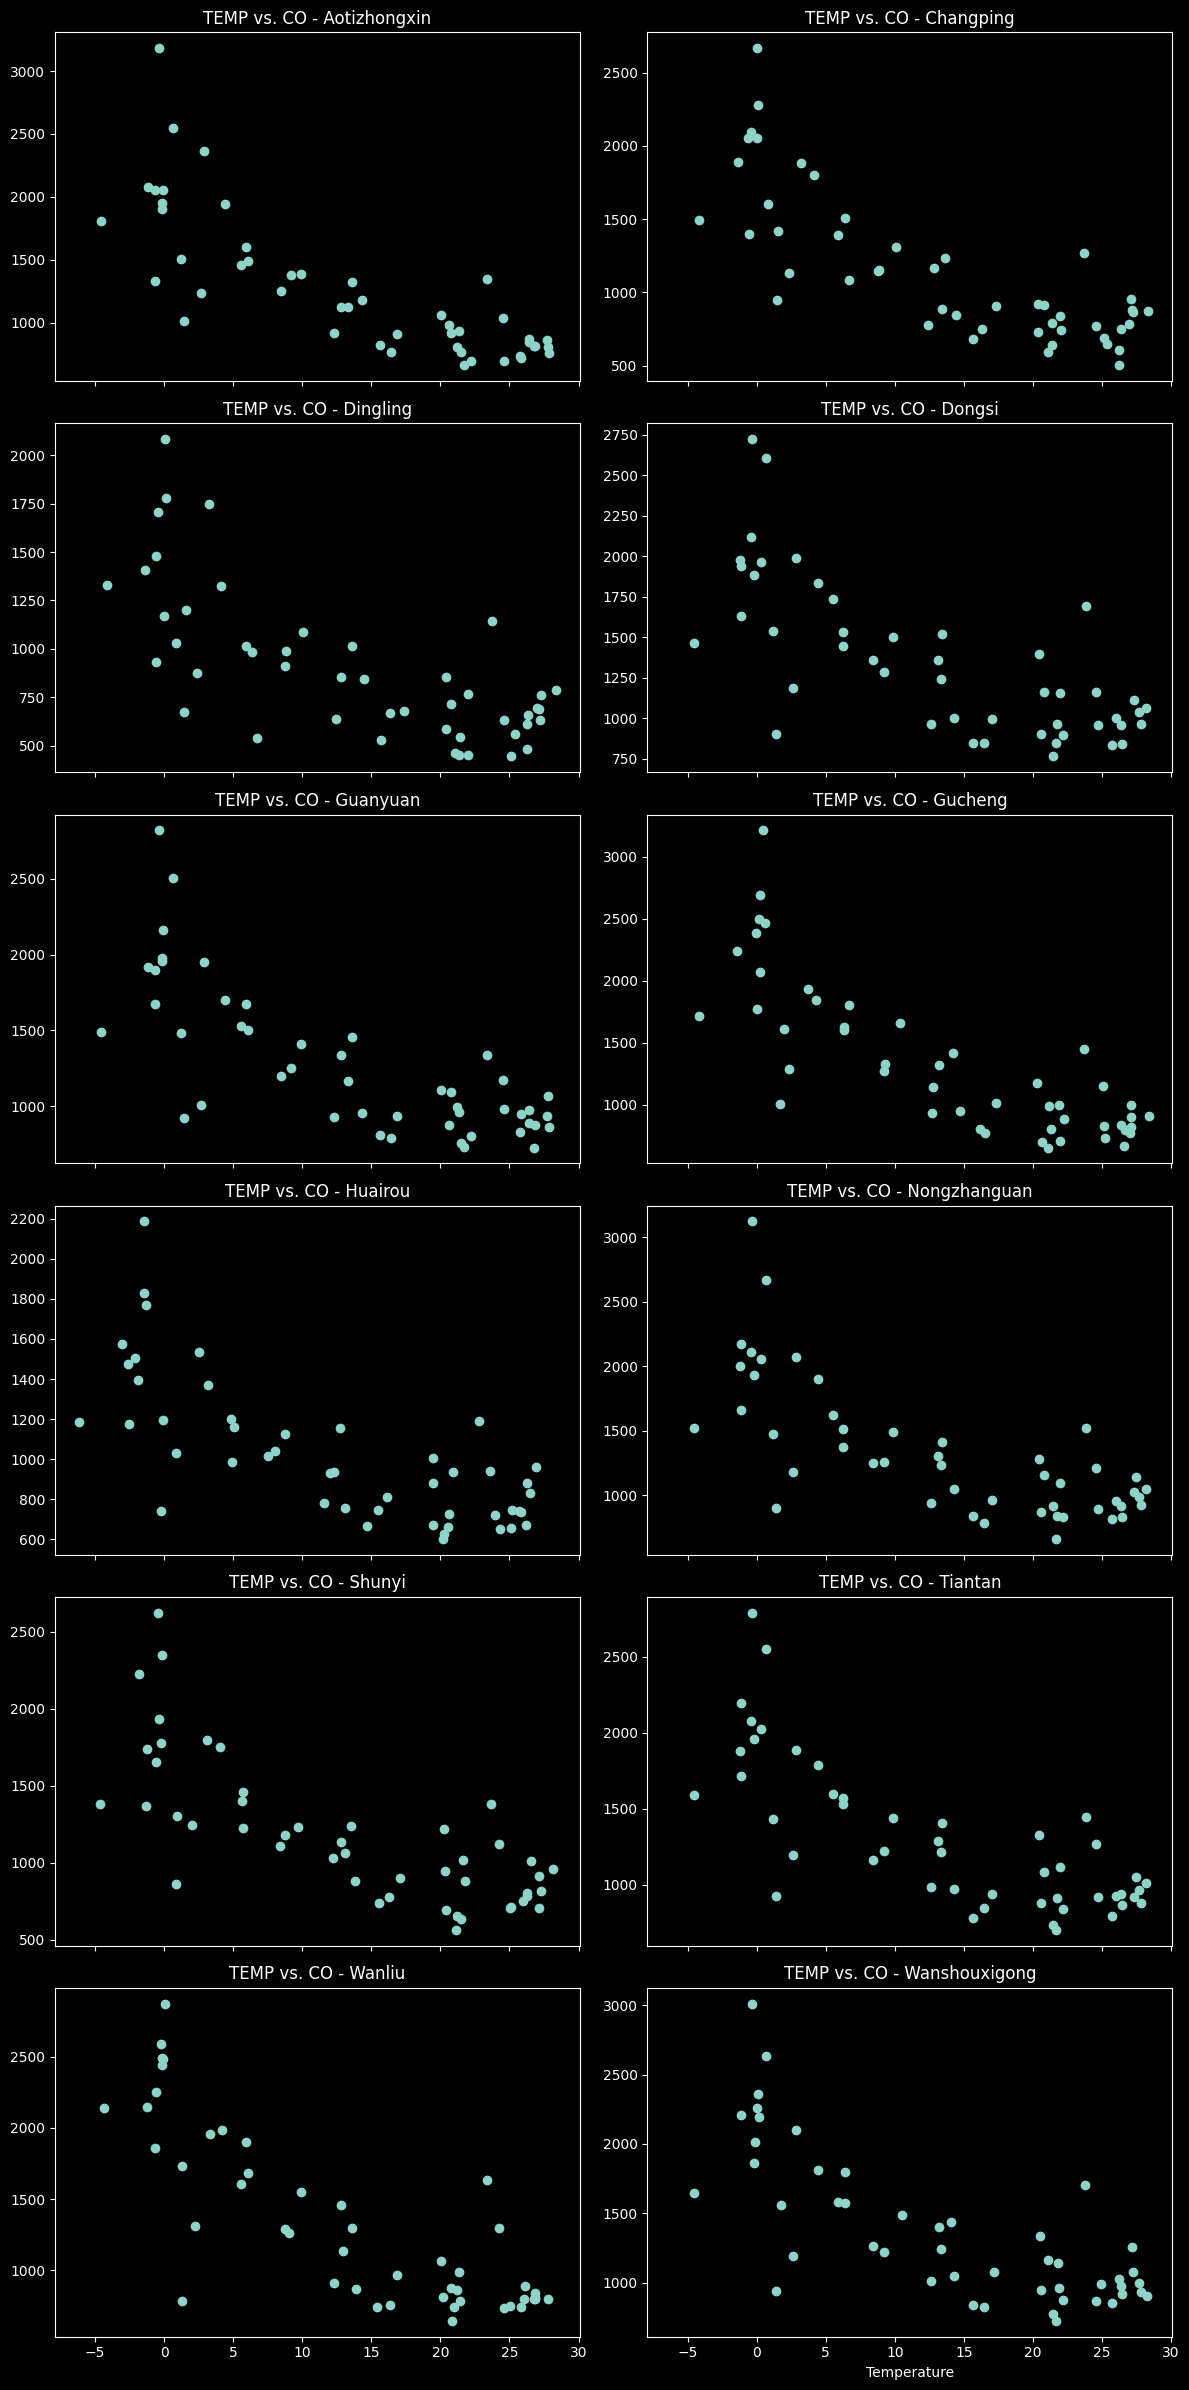

In [40]:
correlation_scatter(df, 'TEMP', 'CO')

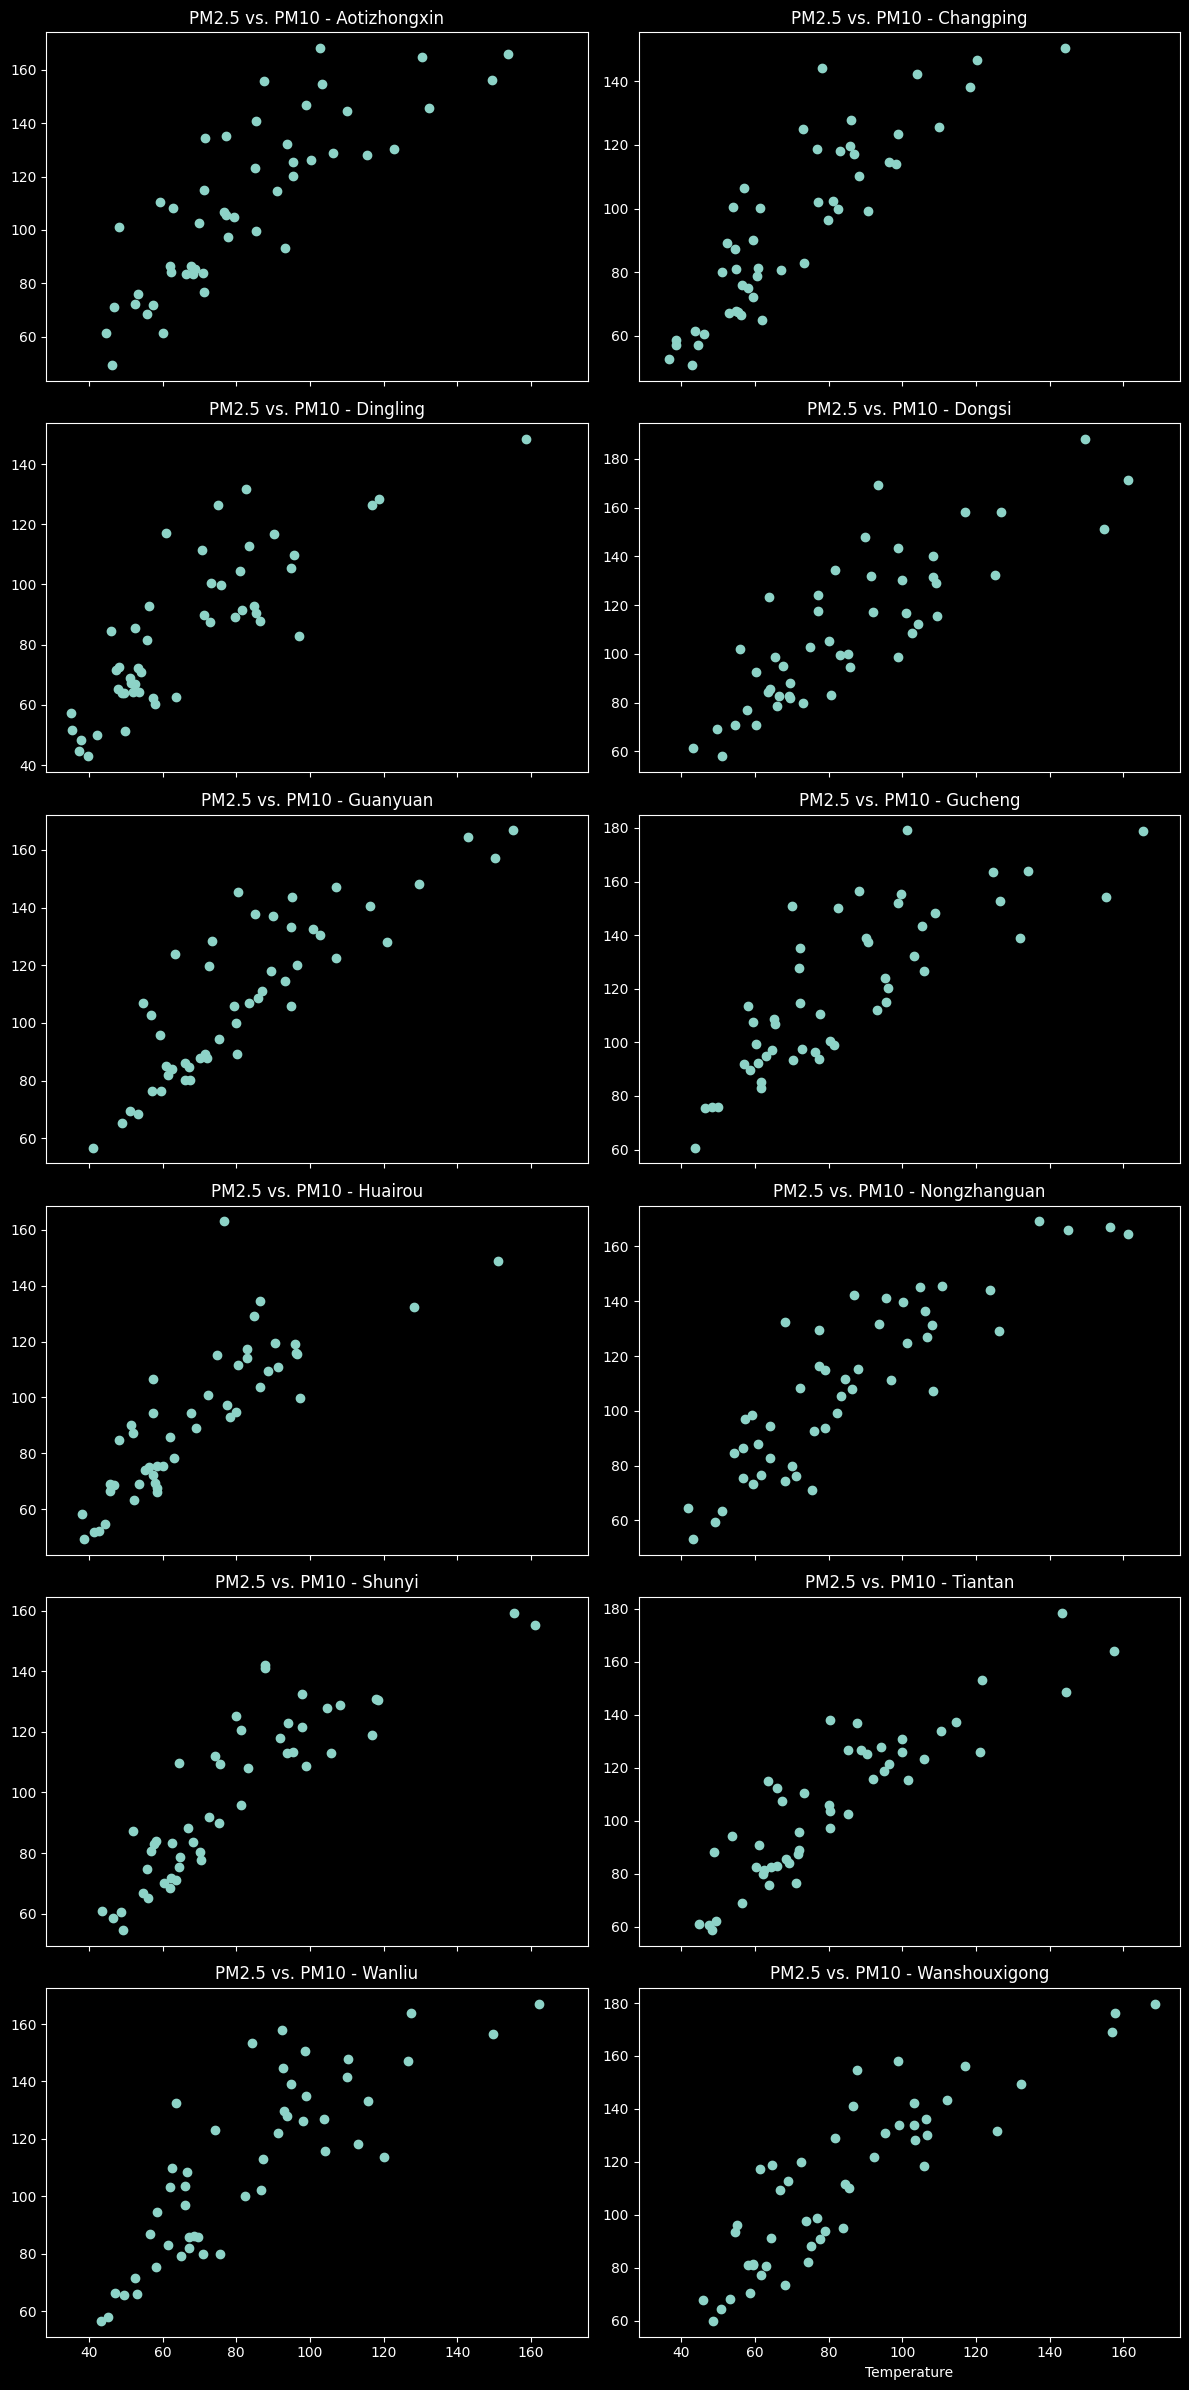

In [41]:
correlation_scatter(df_interp, 'PM2.5', 'PM10')

In [42]:
#station_geo = pd.read_csv('latlong.csv')
#map_center = [39.9042, 116.4074]
#beijing_map = fl.Map(location=map_center)
#
#for _, row in station_geo.iterrows():
#    fl.Marker(
#        location=[row['Latitude'], row['Longitude']],
#        popup=row['Station'],
#        icon=fl.Icon(color='blue', icon='info-sign')
#    ).add_to(beijing_map)
#
#beijing_map